In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import sys
from pathlib import Path
sys.path.append(Path(os.getcwd()).parent.parent.as_posix())

In [3]:
import dgl
import numpy as np
import networkx as nx

import torch
import torch.nn as nn

from functools import partial
from torch.utils.data import Dataset

from tqdm import tqdm
from dataset import get_datasets, ECLDataset
from utils import seed_everything
from constructor import construct_ess, construct_vanilla

import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict

import warnings
warnings.simplefilter("ignore")

/home/perkyfever/miniconda3/envs/project/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Graphs Properties

In [4]:
ALPHA = 0.05
HORIZON_SIZE = 0 # placeholder
LOOKBACK_SIZES = [24, 48, 96, 192, 384]

In [5]:
class GraphDataset(Dataset):
    def __init__(self, dataset: ECLDataset, graph_construction_fn):
        super().__init__()
        self.graphs: list[dgl.DGLGraph] = []
        self.targets: list[torch.Tensor] = []
        for idx in range(len(dataset)):
            x_data, *_ = dataset[idx]
            graph = graph_construction_fn(x_data)
            self.graphs.append(graph)

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx) -> tuple[dgl.DGLGraph, torch.Tensor]:
        return self.graphs[idx]

In [6]:
def get_graph_dataset(dataset, graph_fn) -> GraphDataset:
    return GraphDataset(
        dataset=dataset,
        graph_construction_fn=graph_fn
    )

In [8]:
def get_graph_properties(graphs: list[dgl.graph]) -> dict:
    mean_adj_matrix = np.mean([g.adjacency_matrix().to_dense() for g in graphs], axis=0)
    edges_percentage = np.mean([g.num_edges() / (g.num_nodes() ** 2) for g in graphs])
    mean_node_degree = np.mean([g.in_degrees().float().mean() for g in graphs])
    mean_num_components = np.mean([nx.number_connected_components(g.to_networkx().to_undirected()) for g in graphs])
    return {
        "mean_adj_matrix": mean_adj_matrix,
        "edges_percentage": edges_percentage,
        "mean_node_degree": mean_node_degree,
        "mean_num_components": mean_num_components
    }

## ESS Construction

In [9]:
ess_results = {}
GRAPH_CONSTRUCTION_FN = partial(construct_ess, alpha=ALPHA)

In [10]:
pbar = tqdm(LOOKBACK_SIZES, desc="Graph Construction")
for LOOKBACK_SIZE in tqdm(LOOKBACK_SIZES):
    pbar.set_description(f"Graph Construction {LOOKBACK_SIZE=}")
    electricity, *_ = get_datasets(
        dataset_name="electricity.npy",
        lookback_size=LOOKBACK_SIZE,
        horizon_size=HORIZON_SIZE
    )
    pems, *_ = get_datasets(
        dataset_name="PEMS08.npy",
        lookback_size=LOOKBACK_SIZE,
        horizon_size=HORIZON_SIZE
    )
    ett, *_ = get_datasets(
        dataset_name="ETTh1.csv",
        lookback_size=LOOKBACK_SIZE,
        horizon_size=HORIZON_SIZE
    )
    
    electricity_graphs = get_graph_dataset(electricity, GRAPH_CONSTRUCTION_FN)
    pems_graphs = get_graph_dataset(pems, GRAPH_CONSTRUCTION_FN)
    ett_graphs = get_graph_dataset(ett, GRAPH_CONSTRUCTION_FN)
    
    ess_results[LOOKBACK_SIZE] = {
        "electricity": get_graph_properties(electricity_graphs),
        "pems": get_graph_properties(pems_graphs),
        "ett": get_graph_properties(ett_graphs),
    }

100%|██████████| 5/5 [17:40<00:00, 212.19s/it]       | 0/5 [13:58<?, ?it/s]


# Vanilla Construction

In [11]:
vanilla_results = {}
GRAPH_CONSTRUCTION_FN = partial(construct_vanilla, alpha=ALPHA)

In [12]:
pbar = tqdm(LOOKBACK_SIZES, desc="Graph Construction")
for LOOKBACK_SIZE in tqdm(LOOKBACK_SIZES):
    pbar.set_description(f"Graph Construction {LOOKBACK_SIZE=}")
    electricity, *_ = get_datasets(
        dataset_name="electricity.npy",
        lookback_size=LOOKBACK_SIZE,
        horizon_size=HORIZON_SIZE
    )
    pems, *_ = get_datasets(
        dataset_name="PEMS08.npy",
        lookback_size=LOOKBACK_SIZE,
        horizon_size=HORIZON_SIZE
    )
    ett, *_ = get_datasets(
        dataset_name="ETTh1.csv",
        lookback_size=LOOKBACK_SIZE,
        horizon_size=HORIZON_SIZE
    )
    
    electricity_graphs = get_graph_dataset(electricity, GRAPH_CONSTRUCTION_FN)
    pems_graphs = get_graph_dataset(pems, GRAPH_CONSTRUCTION_FN)
    ett_graphs = get_graph_dataset(ett, GRAPH_CONSTRUCTION_FN)
    
    vanilla_results[LOOKBACK_SIZE] = {
        "electricity": get_graph_properties(electricity_graphs),
        "pems": get_graph_properties(pems_graphs),
        "ett": get_graph_properties(ett_graphs),
    }

100%|██████████| 5/5 [14:17<00:00, 171.50s/it]


# Adjacency matrix

## ESS Construction

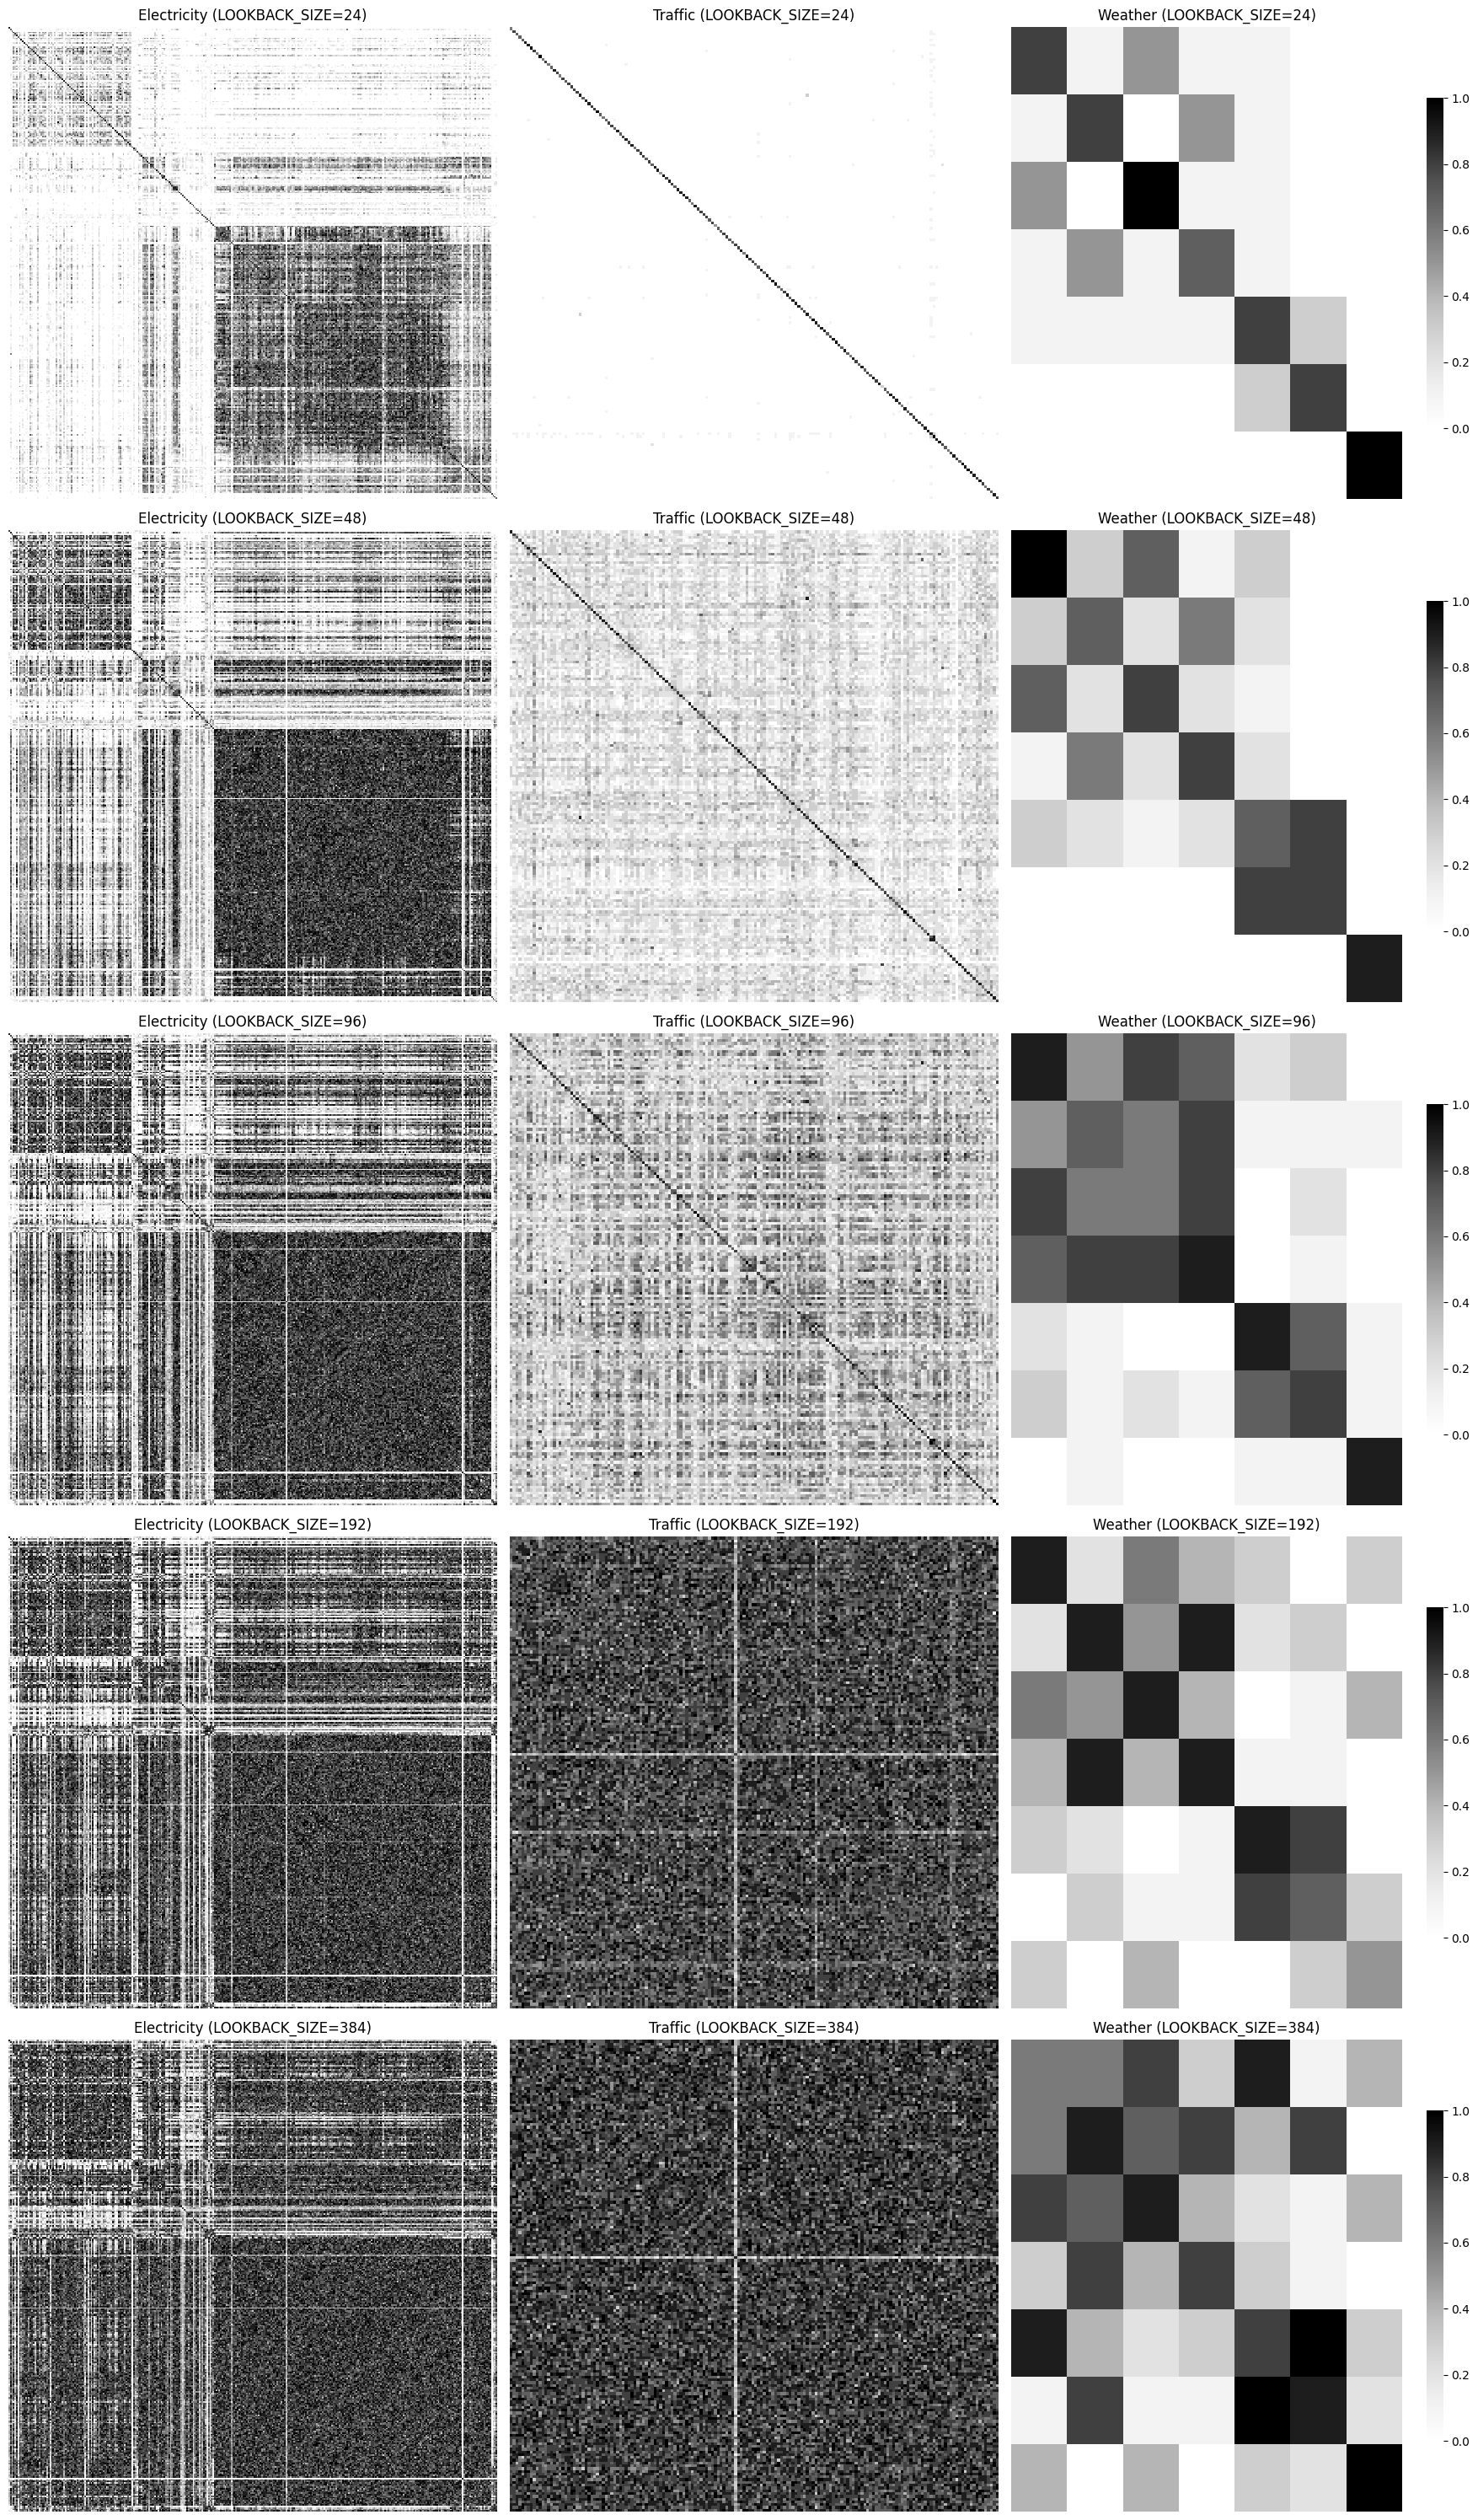

In [13]:
fig, axes = plt.subplots(len(LOOKBACK_SIZES), 3, figsize=(18, 6 * len(LOOKBACK_SIZES)))
for idx, LOOKBACK_SIZE in enumerate(LOOKBACK_SIZES):
    sns.heatmap(
        ess_results[LOOKBACK_SIZE]["electricity"]["mean_adj_matrix"],
        ax=axes[idx][0],
        cmap="Greys",
        vmin=0,
        vmax=1,
        xticklabels=False,
        yticklabels=False,
        cbar=False
    )
    axes[idx][0].set_title(f"Electricity ({LOOKBACK_SIZE=})")
    axes[idx][0].tick_params(left=False, bottom=False)

    sns.heatmap(
        ess_results[LOOKBACK_SIZE]["pems"]["mean_adj_matrix"],
        ax=axes[idx][1],
        cmap="Greys",
        vmin=0,
        vmax=1,
        xticklabels=False,
        yticklabels=False,
        cbar=False
    )
    axes[idx][1].set_title(f"Traffic ({LOOKBACK_SIZE=})")
    axes[idx][1].tick_params(left=False, bottom=False)

    sns.heatmap(
        ess_results[LOOKBACK_SIZE]["ett"]["mean_adj_matrix"],
        ax=axes[idx][2],
        cmap="Greys",
        vmin=0,
        vmax=1,
        xticklabels=False,
        yticklabels=False,
        cbar=True,
        cbar_kws={"shrink": 0.7}
    )
    axes[idx][2].set_title(f"Weather ({LOOKBACK_SIZE=})")
    axes[idx][2].tick_params(left=False, bottom=False)

plt.tight_layout()
plt.show();

## Vanilla Construction

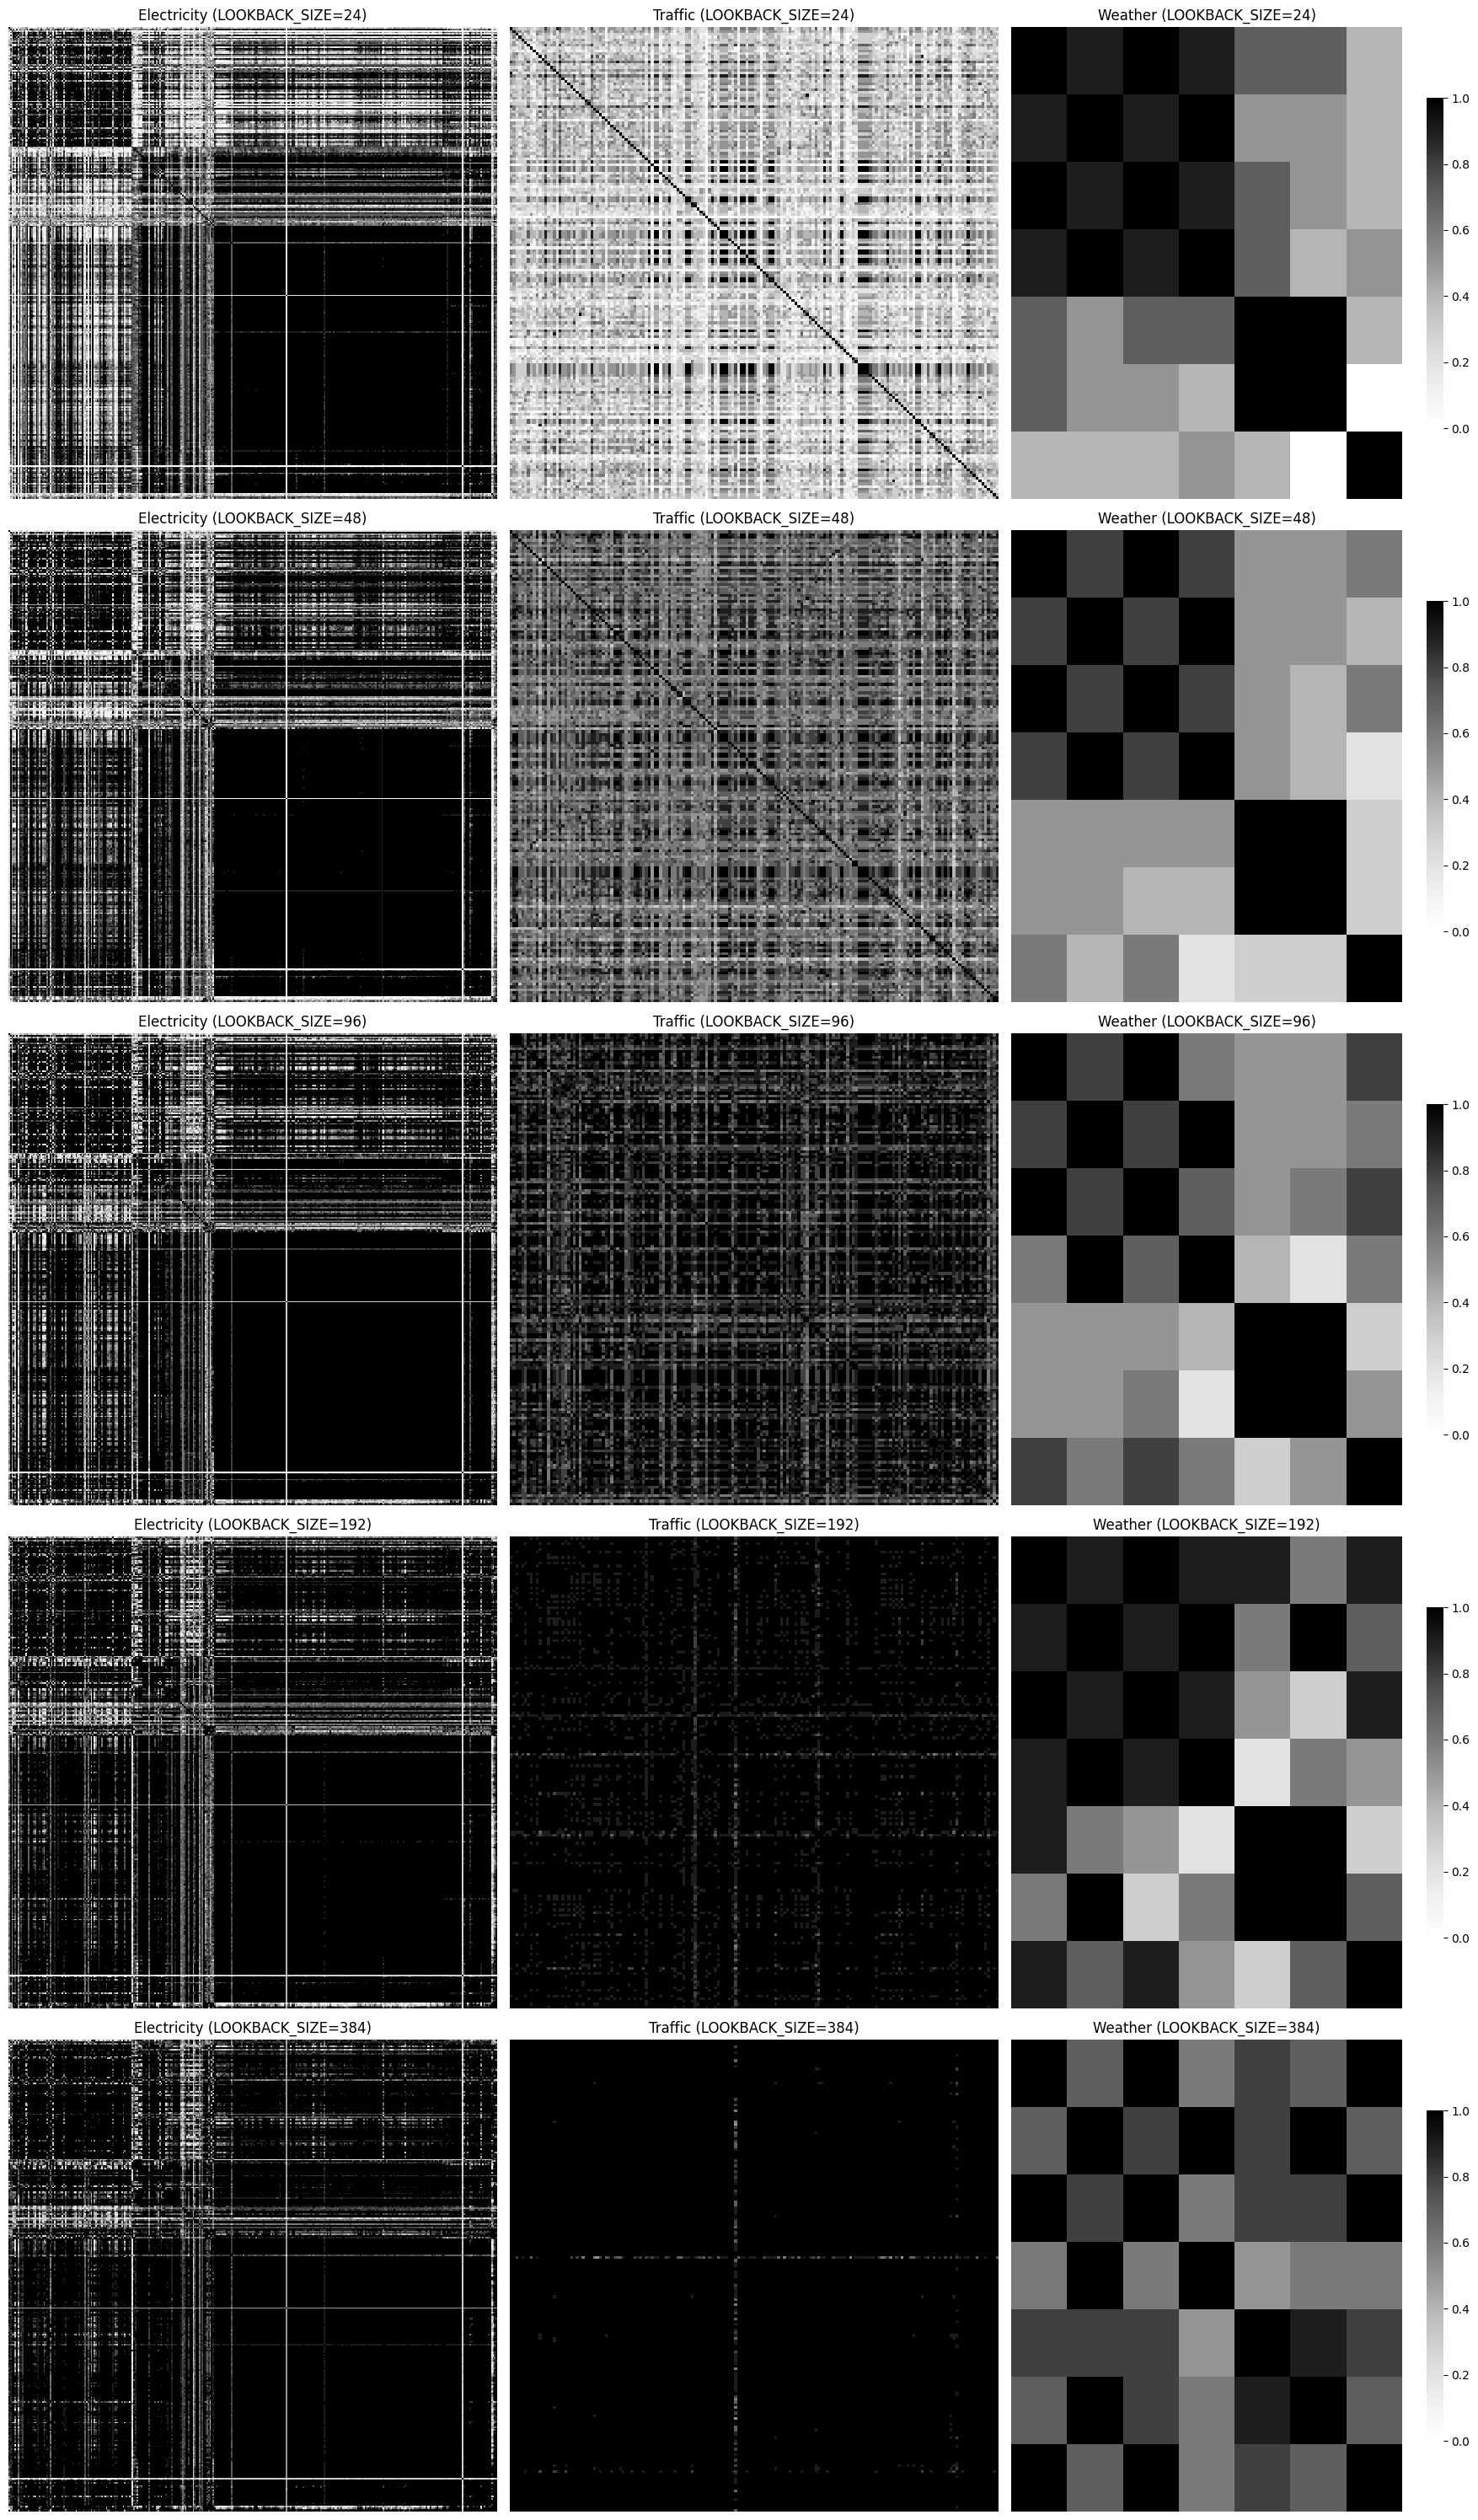

In [14]:
fig, axes = plt.subplots(len(LOOKBACK_SIZES), 3, figsize=(18, 6 * len(LOOKBACK_SIZES)))
for idx, LOOKBACK_SIZE in enumerate(LOOKBACK_SIZES):
    sns.heatmap(
        vanilla_results[LOOKBACK_SIZE]["electricity"]["mean_adj_matrix"],
        ax=axes[idx][0],
        cmap="Greys",
        vmin=0,
        vmax=1,
        xticklabels=False,
        yticklabels=False,
        cbar=False
    )
    axes[idx][0].set_title(f"Electricity ({LOOKBACK_SIZE=})")
    axes[idx][0].tick_params(left=False, bottom=False)

    sns.heatmap(
        vanilla_results[LOOKBACK_SIZE]["pems"]["mean_adj_matrix"],
        ax=axes[idx][1],
        cmap="Greys",
        vmin=0,
        vmax=1,
        xticklabels=False,
        yticklabels=False,
        cbar=False
    )
    axes[idx][1].set_title(f"Traffic ({LOOKBACK_SIZE=})")
    axes[idx][1].tick_params(left=False, bottom=False)

    sns.heatmap(
        vanilla_results[LOOKBACK_SIZE]["ett"]["mean_adj_matrix"],
        ax=axes[idx][2],
        cmap="Greys",
        vmin=0,
        vmax=1,
        xticklabels=False,
        yticklabels=False,
        cbar=True,
        cbar_kws={"shrink": 0.7}
    )
    axes[idx][2].set_title(f"Weather ({LOOKBACK_SIZE=})")
    axes[idx][2].tick_params(left=False, bottom=False)

plt.tight_layout()
plt.show();

# Edges Percentage

In [15]:
ess_mean_edges_percentage = {
    'electricity': [ess_results[LOOKBACK_SIZE]['electricity']['edges_percentage'] for LOOKBACK_SIZE in LOOKBACK_SIZES],
    'pems': [ess_results[LOOKBACK_SIZE]['pems']['edges_percentage'] for LOOKBACK_SIZE in LOOKBACK_SIZES],
    'ett': [ess_results[LOOKBACK_SIZE]['ett']['edges_percentage'] for LOOKBACK_SIZE in LOOKBACK_SIZES],
}

vanilla_mean_edges_percentage = {
    'electricity': [vanilla_results[LOOKBACK_SIZE]['electricity']['edges_percentage'] for LOOKBACK_SIZE in LOOKBACK_SIZES],
    'pems': [vanilla_results[LOOKBACK_SIZE]['pems']['edges_percentage'] for LOOKBACK_SIZE in LOOKBACK_SIZES],
    'ett': [vanilla_results[LOOKBACK_SIZE]['ett']['edges_percentage'] for LOOKBACK_SIZE in LOOKBACK_SIZES],
}

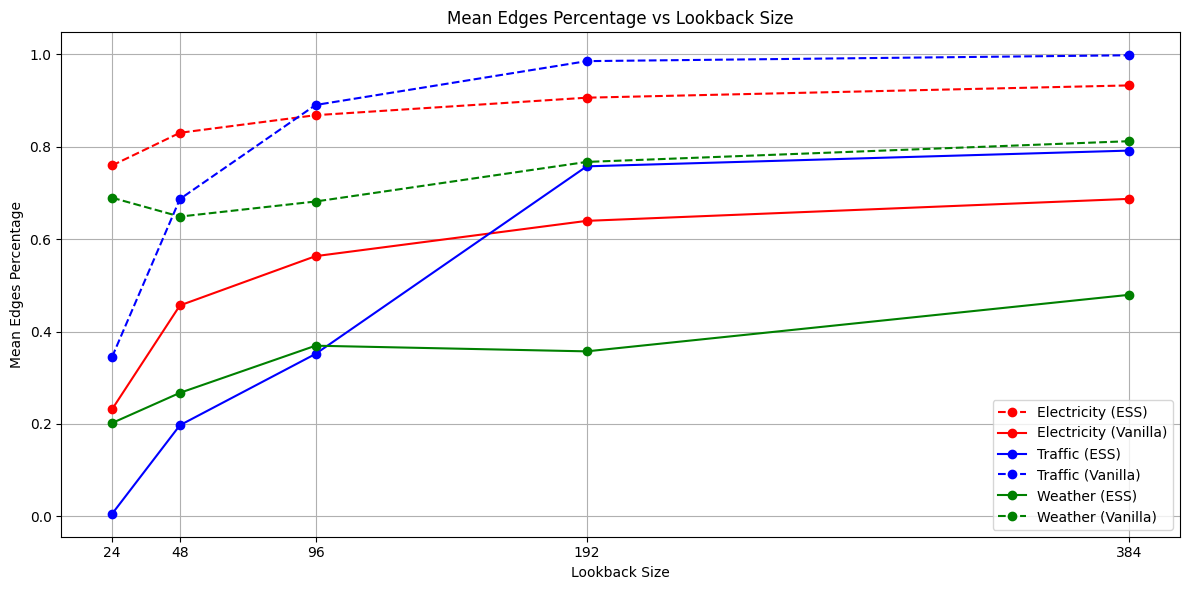

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(LOOKBACK_SIZES, ess_mean_edges_percentage['electricity'], label='Electricity (ESS)', marker='o', linestyle='--', color='red')
plt.plot(LOOKBACK_SIZES, vanilla_mean_edges_percentage['electricity'], label='Electricity (Vanilla)', marker='o', color='red')
plt.plot(LOOKBACK_SIZES, ess_mean_edges_percentage['pems'], label='Traffic (ESS)', marker='o', color='blue')
plt.plot(LOOKBACK_SIZES, vanilla_mean_edges_percentage['pems'], label='Traffic (Vanilla)', marker='o', linestyle='--', color='blue')
plt.plot(LOOKBACK_SIZES, ess_mean_edges_percentage['ett'], label='Weather (ESS)', marker='o', color='green')
plt.plot(LOOKBACK_SIZES, vanilla_mean_edges_percentage['ett'], label='Weather (Vanilla)', marker='o', linestyle='--', color='green')
plt.xlabel('Lookback Size')
plt.ylabel('Mean Edges Percentage')
plt.title('Mean Edges Percentage vs Lookback Size')
plt.xticks(LOOKBACK_SIZES)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Nodes Degrees

In [27]:
ess_mean_node_degree = {
    'electricity': [ess_results[LOOKBACK_SIZE]['electricity']['mean_node_degree'] for LOOKBACK_SIZE in LOOKBACK_SIZES],
    'pems': [ess_results[LOOKBACK_SIZE]['pems']['mean_node_degree'] for LOOKBACK_SIZE in LOOKBACK_SIZES],
    'ett': [ess_results[LOOKBACK_SIZE]['ett']['mean_node_degree'] for LOOKBACK_SIZE in LOOKBACK_SIZES],
}

vanilla_mean_node_degree = {
    'electricity': [vanilla_results[LOOKBACK_SIZE]['electricity']['mean_node_degree'] for LOOKBACK_SIZE in LOOKBACK_SIZES],
    'pems': [vanilla_results[LOOKBACK_SIZE]['pems']['mean_node_degree'] for LOOKBACK_SIZE in LOOKBACK_SIZES],
    'ett': [vanilla_results[LOOKBACK_SIZE]['ett']['mean_node_degree'] for LOOKBACK_SIZE in LOOKBACK_SIZES],
}

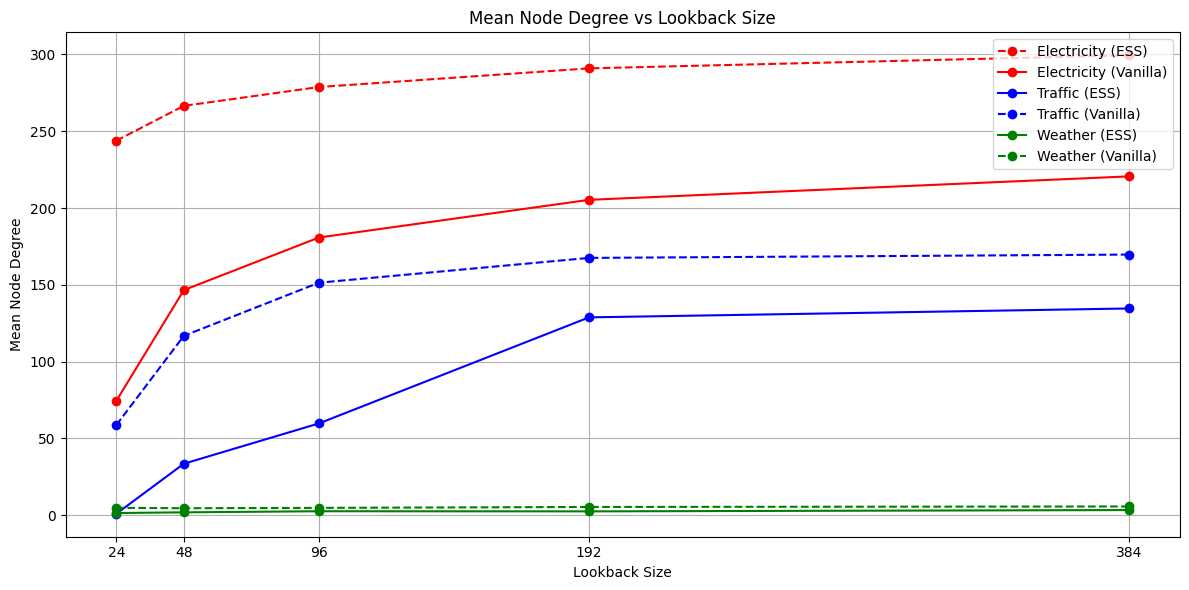

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(LOOKBACK_SIZES, ess_mean_node_degree['electricity'], label='Electricity (ESS)', marker='o', linestyle='--', color='red')
plt.plot(LOOKBACK_SIZES, vanilla_mean_node_degree['electricity'], label='Electricity (Vanilla)', marker='o', color='red')
plt.plot(LOOKBACK_SIZES, ess_mean_node_degree['pems'], label='Traffic (ESS)', marker='o', color='blue')
plt.plot(LOOKBACK_SIZES, vanilla_mean_node_degree['pems'], label='Traffic (Vanilla)', marker='o', linestyle='--', color='blue')
plt.plot(LOOKBACK_SIZES, ess_mean_node_degree['ett'], label='Weather (ESS)', marker='o', color='green')
plt.plot(LOOKBACK_SIZES, vanilla_mean_node_degree['ett'], label='Weather (Vanilla)', marker='o', linestyle='--', color='green')
plt.xlabel('Lookback Size')
plt.ylabel('Mean Node Degree')
plt.title('Mean Node Degree vs Lookback Size')
plt.xticks(LOOKBACK_SIZES)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Number of Components

In [33]:
ess_mean_num_components = {
    'electricity': [ess_results[LOOKBACK_SIZE]['electricity']['mean_num_components'] for LOOKBACK_SIZE in LOOKBACK_SIZES],
    'pems': [ess_results[LOOKBACK_SIZE]['pems']['mean_num_components'] for LOOKBACK_SIZE in LOOKBACK_SIZES],
    'ett': [ess_results[LOOKBACK_SIZE]['ett']['mean_num_components'] for LOOKBACK_SIZE in LOOKBACK_SIZES],
}

vanilla_mean_num_components = {
    'electricity': [vanilla_results[LOOKBACK_SIZE]['electricity']['mean_num_components'] for LOOKBACK_SIZE in LOOKBACK_SIZES],
    'pems': [vanilla_results[LOOKBACK_SIZE]['pems']['mean_num_components'] for LOOKBACK_SIZE in LOOKBACK_SIZES],
    'ett': [vanilla_results[LOOKBACK_SIZE]['ett']['mean_num_components'] for LOOKBACK_SIZE in LOOKBACK_SIZES],
}

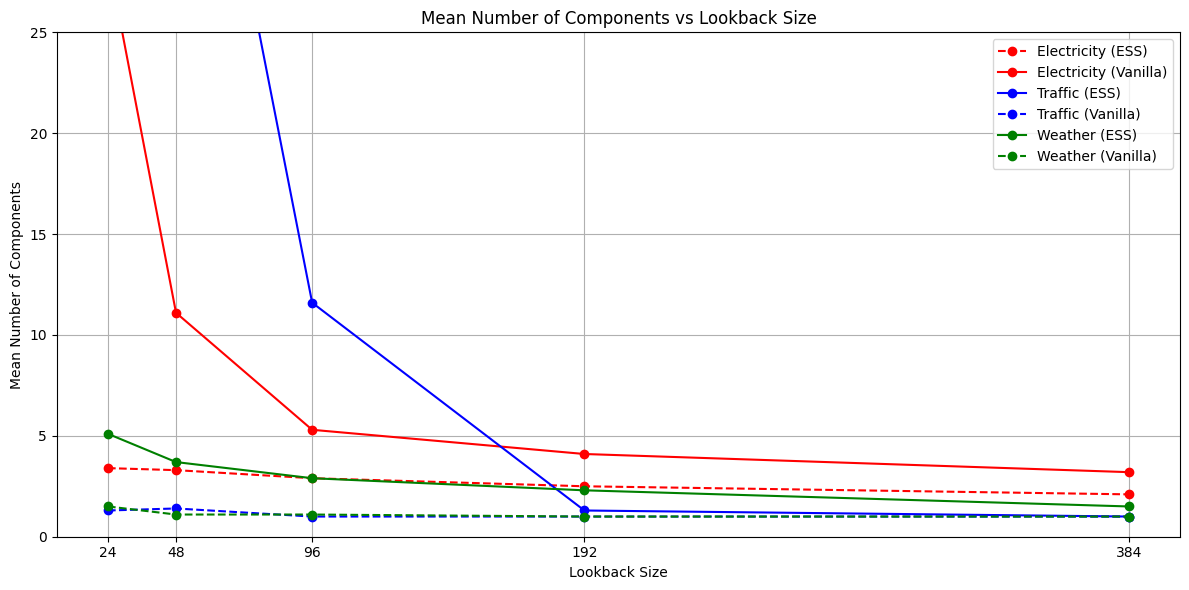

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(LOOKBACK_SIZES, ess_mean_num_components['electricity'], label='Electricity (ESS)', marker='o', linestyle='--', color='red')
plt.plot(LOOKBACK_SIZES, vanilla_mean_num_components['electricity'], label='Electricity (Vanilla)', marker='o', color='red')
plt.plot(LOOKBACK_SIZES, ess_mean_num_components['pems'], label='Traffic (ESS)', marker='o', color='blue')
plt.plot(LOOKBACK_SIZES, vanilla_mean_num_components['pems'], label='Traffic (Vanilla)', marker='o', linestyle='--', color='blue')
plt.plot(LOOKBACK_SIZES, ess_mean_num_components['ett'], label='Weather (ESS)', marker='o', color='green')
plt.plot(LOOKBACK_SIZES, vanilla_mean_num_components['ett'], label='Weather (Vanilla)', marker='o', linestyle='--', color='green')
plt.xlabel('Lookback Size')
plt.ylabel('Mean Number of Components')
plt.title('Mean Number of Components vs Lookback Size')
plt.xticks(LOOKBACK_SIZES)
plt.ylim(0, 25)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [38]:
pems[0][0].shape

torch.Size([384, 170])